In [12]:
import sys
sys.path.append('../src/') 

import importlib
import fonctions_couleur  # Import the module directly
import numpy as np
 # Ajouter le chemin du dossier contenant le fichier

import fonctions_image  # Importer toutes les fonctions du fichier

# Reload the module to ensure updates are reflected
importlib.reload(fonctions_couleur)
importlib.reload(fonctions_image)

# Now you can use the module, or re-import functions
from fonctions_couleur import *  # Re-import functions if needed
from fonctions_image import *  # Re-import functions if needed

Found 13 valid pieces
Piece areas: [119643, 137857, 127295, 115684, 143516, 114006, 143175, 118566, 130832, 122847, 154187, 138620, 158065]


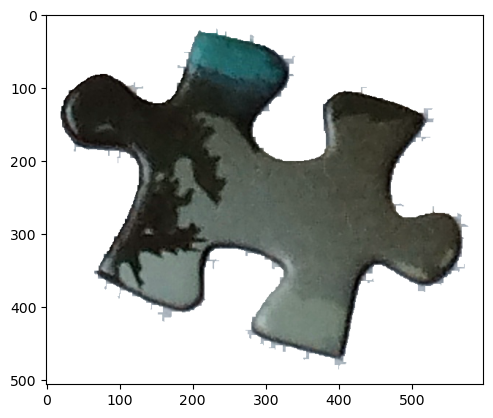

In [13]:
puzzle_yak=cv2.imread('../puzzles/yakari.jpg')
photo_yak=cv2.imread('../notebooks/test_2.jpg')
pieces=extract_pieces(photo_yak)
piece_temp=pieces[2]["matching_image"]
grid_yak=split_image_to_grid(puzzle_yak, 7, 7)
plt.imshow(piece_temp)

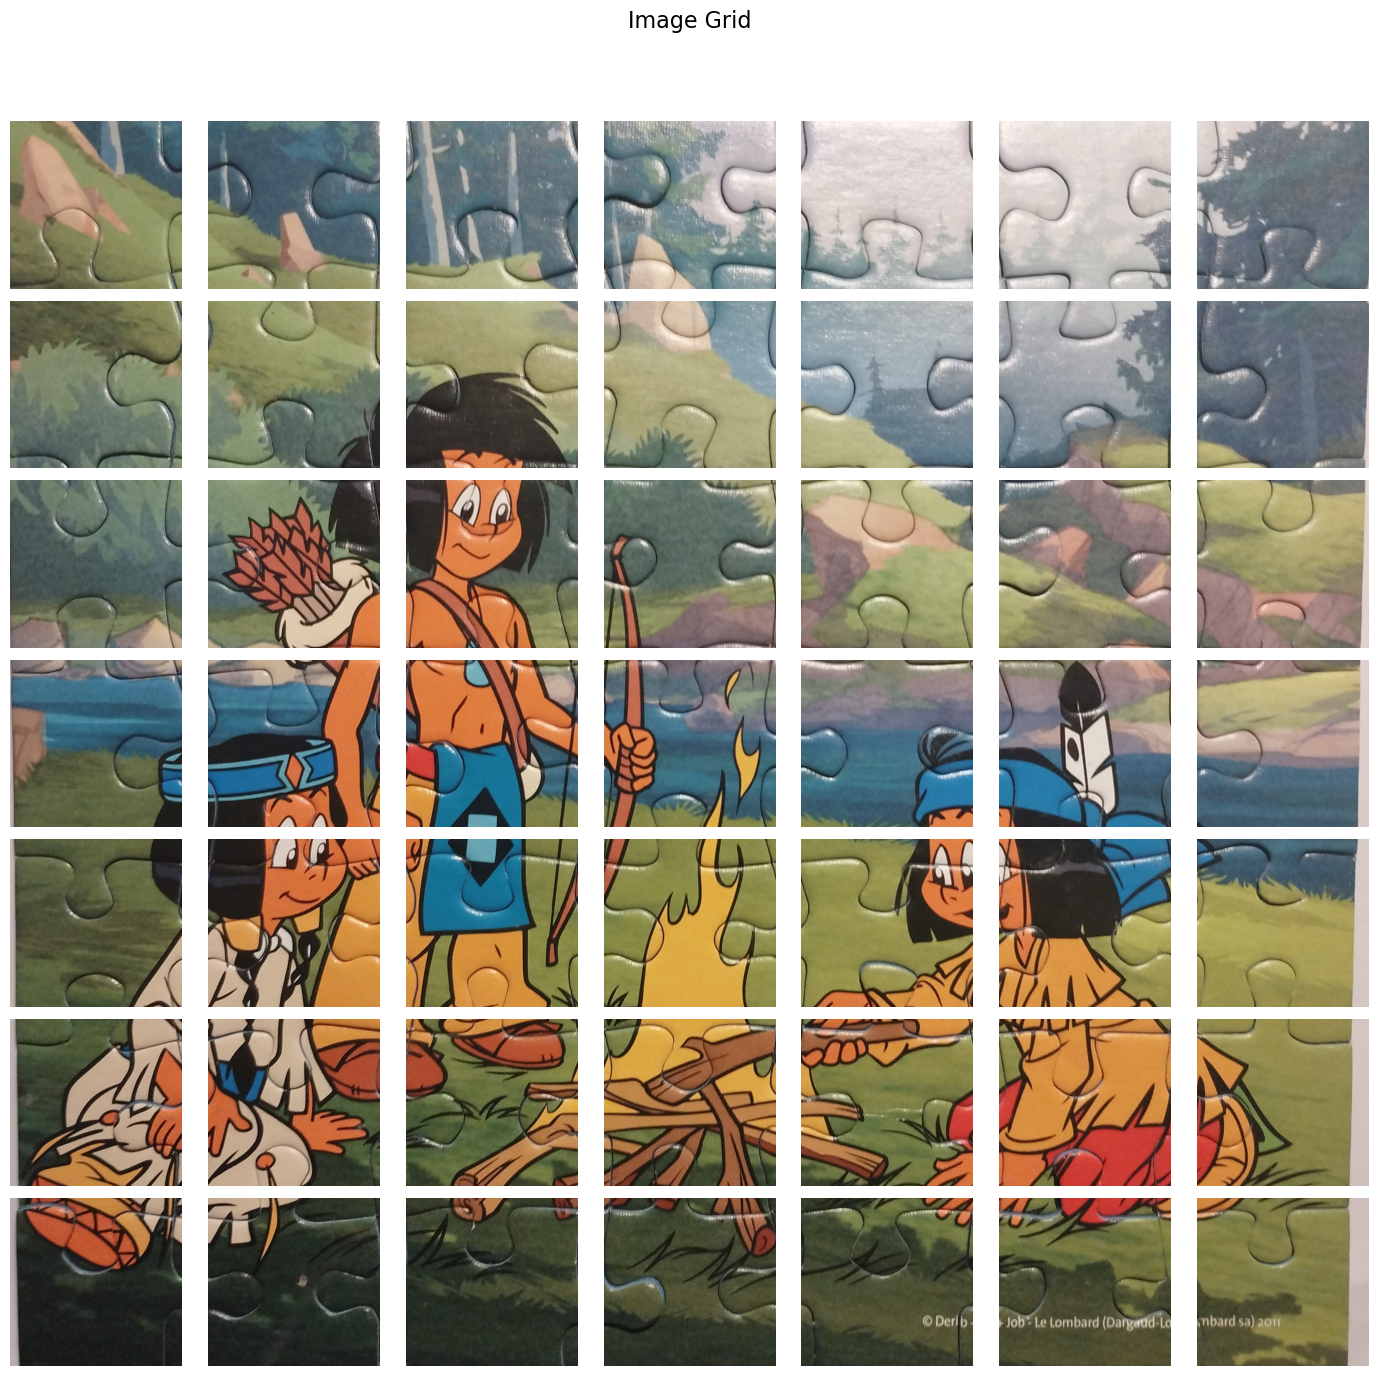

In [14]:
display_image_grid(grid_yak)

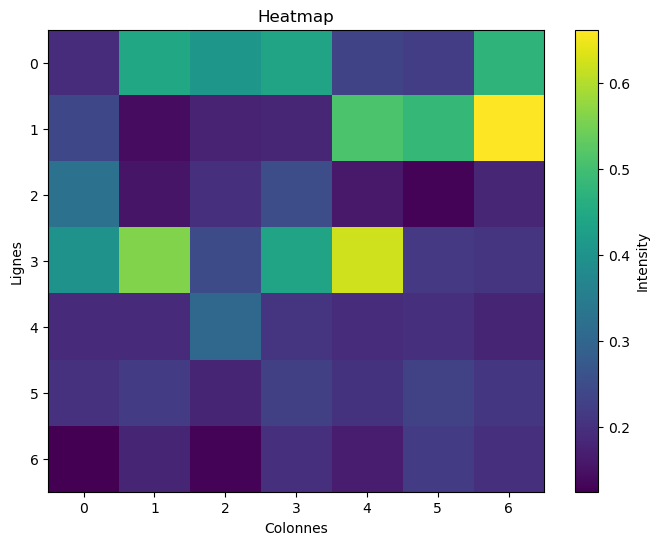

In [15]:
sim_matrix=compute_similarity_matrix( grid_yak, piece_temp)
display_heatmap(sim_matrix)

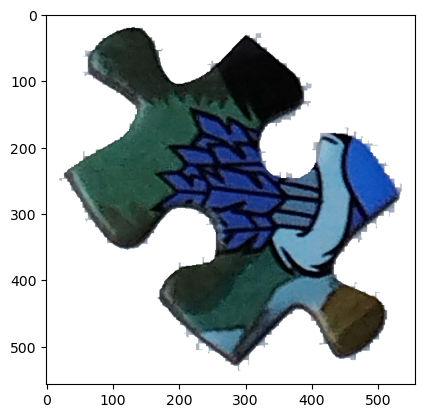

In [16]:

plt.imshow(pieces[1]['matching_image'])



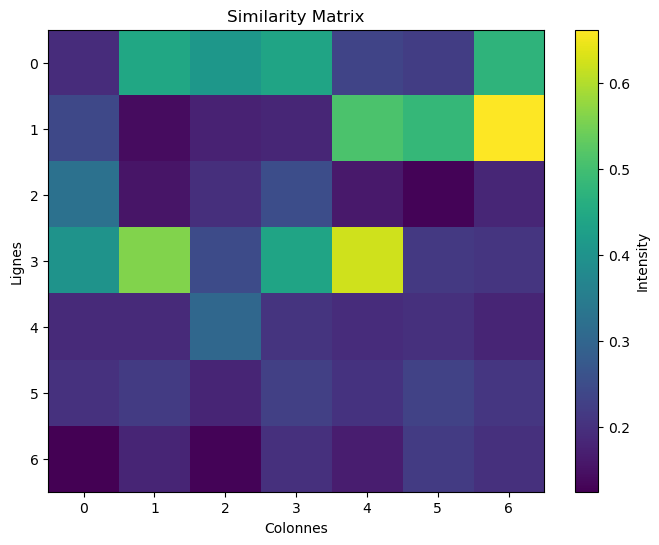

In [17]:
display_heatmap(sim_matrix, title="Similarity Matrix", cmap="viridis")

## calcul d'homographie pour avoir un scaling

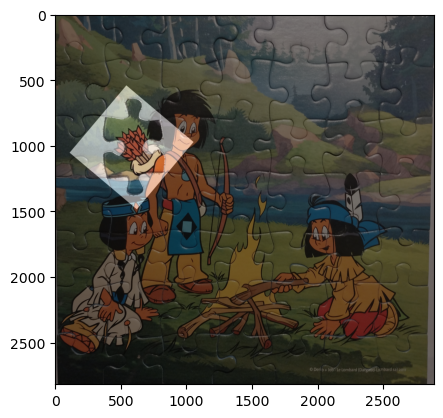

1.2038087467072802


In [18]:
sift=cv2.SIFT_create()
piece1=pieces[1]
piece_im=piece1["matching_image"]
puzzle=puzzle_yak
kp_im, des_im=calculate_keypoints_sift(sift,piece1)

kp_puzzle, des_puzzle=sift.detectAndCompute(puzzle, None)
matches=calculate_matches(piece1,puzzle,kp_im,des_im, kp_puzzle,des_puzzle,np.ones(puzzle_yak.shape[:2], dtype=np.uint8) * 255 )



#s, theta, t=estimate_rigid_transform(src_points, dst_points)
Hs=homography_unknown_scale(kp_im, kp_puzzle, matches )
s, theta, t=decompose_similarity_homography(Hs)
show_homography_on_puzzle(piece_im, puzzle, Hs)

print (s)

## méthode 2 

In [19]:
m0 = pieces[2]["matching_image"]
mask0 = pieces[2]["binary_mask"]
### rotate them by 90 degrees
m0 = np.rot90(m0, -1)
mask0 = np.rot90(mask0, -1)
mask_puzzle = np.ones(puzzle_yak.shape[:2], dtype=np.uint8) * 255
square_size_puzzle = 60
s = 2  # Example scaling factor (adjust as needed)
square_size_im = int(square_size_puzzle / s)

# Create descriptor for the piece with a margin around the mask
des0 = create_descriptor(m0, get_mask_with_margin(mask0, margin=15), square_size_im, crop_to_mask=True)

# Create descriptor for the puzzle
des_puzzle = create_descriptor(puzzle_yak, mask_puzzle, square_size_puzzle, crop_to_mask=False)

# Display the descriptors
# display_descriptor(m0, des0)
# display_descriptor(puzzle_yak, des_puzzle)

# Search for the piece in the puzzle
matches, map = search_puzzle_for_piece(puzzle_yak, mask_puzzle, m0, mask0, square_size_puzzle, square_size_im, 15)




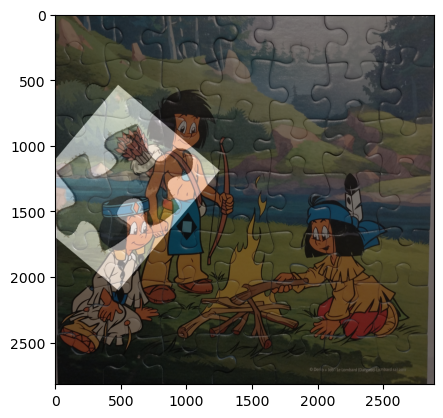

In [20]:
pos, dis=matches[1]


# Compute the homography matrix
H = homography_matrix(s, theta, pos)

# Display the result
show_homography_on_puzzle(m0, puzzle_yak, H)

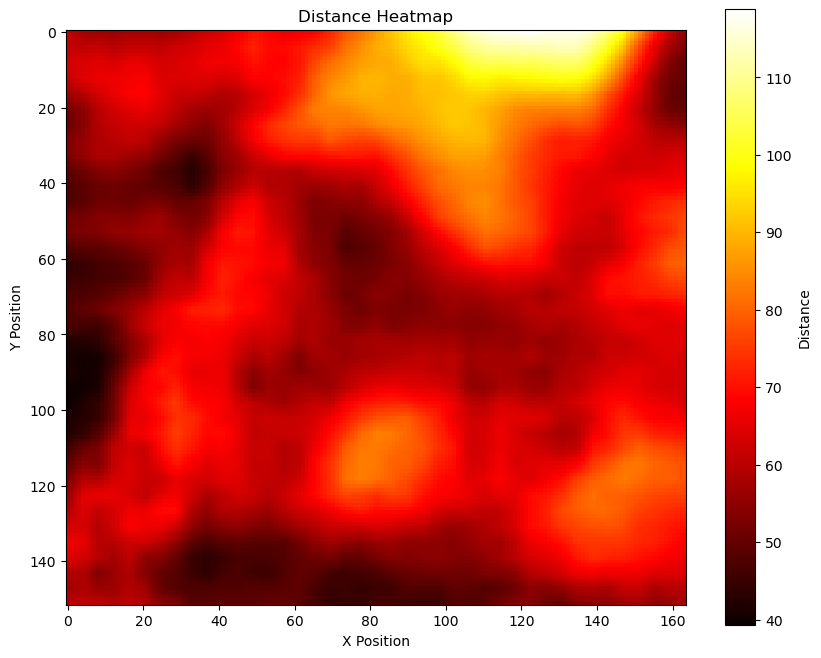

In [21]:
from scipy.ndimage import zoom

def display_distance_heatmap(distance_map, puzzle_square_size, interpolation_factor=4):
    """
    Display the distance map as a heatmap with improved readability through interpolation.

    Parameters:
        distance_map (numpy array): 2D array representing distances at each position.
        puzzle_square_size (int): Size of the square blocks in the puzzle.
        interpolation_factor (int): Factor to upscale the distance map for smoother visualization.
    """
    # Replace NaN values with the maximum distance for better visualization
    distance_map_display = np.copy(distance_map)
    nan_mask = np.isnan(distance_map_display)
    distance_map_display[nan_mask] = np.max(distance_map_display[~nan_mask]) + 1

    # Interpolate the distance map to make it smoother
    distance_map_interpolated = zoom(distance_map_display, interpolation_factor, order=1)

    # Display the interpolated heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(distance_map_interpolated, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Distance')
    plt.title('Distance Heatmap')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

display_distance_heatmap(map, square_size_puzzle, interpolation_factor=4)